# Logistic Regression Post Class

### Importing necessary libraries



In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,6)

## Read in the data

In [211]:
# Training Data

train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [212]:
train.shape

(891, 12)

The training data has 891 observations and 12 features (variables) including the TARGET (the label we want to predict).In this case we want to predict whether a passenger on Titanic **survived** or not.

In [213]:
# Testing Data

test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [214]:
test.shape

(418, 11)

## Exploratory Data Analysis(EDA)

The data page on Kaggle describes the columns in detail. It’s always worth exploring this in detail to get a full understanding of the data.
https://www.kaggle.com/code/parulpandey/deep-dive-into-logistic-regression-for-beginners


### Examining the Distribution of the Target Column 

In [215]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

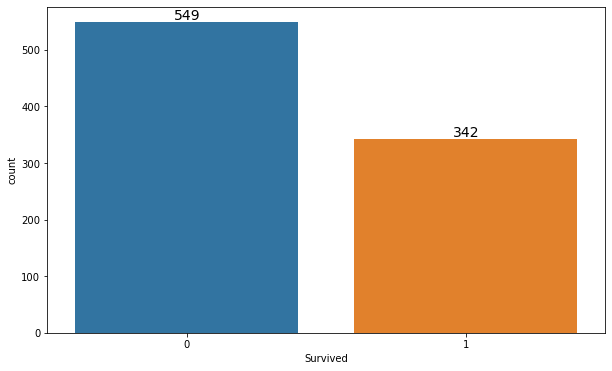

In [216]:
ax = sns.countplot(x = "Survived", data=train)

for i in ax.containers:
    ax.bar_label(i, size =14)

Thus, around 549 people perished while 342 survived.

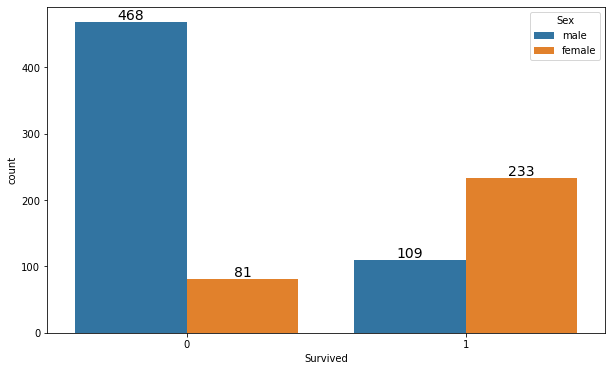

In [217]:
ax = sns.countplot(x= "Survived", hue = "Sex", data=train)

for i in ax.containers:
    ax.bar_label(i, size =14)

We can see that females survived in much higher proportions than males did. Now, Let’s see how many people survived divided by class.

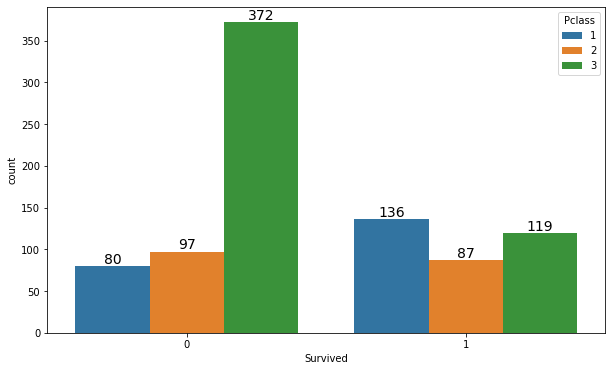

In [218]:
ax = sns.countplot(x ="Survived", hue = "Pclass", data=train)

for i in ax.containers:
    ax.bar_label(i, size=14)

Distribution of survival rate class wise

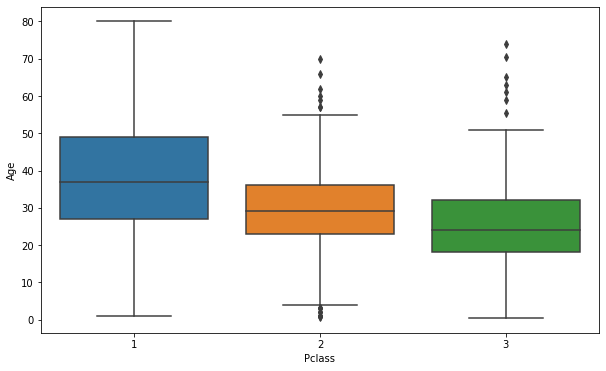

In [219]:
sns.boxplot(x = "Pclass", y = "Age", data=train);

## Examining Missing Values

Next we can look at the number and percentage of missing values in each column.

In [220]:
print("Null in Training set")
print("---------------------")
print(train.isnull().sum())
print("---------------------")
print("Null in Testing set")
print("---------------------")
print(test.isnull().sum())

Null in Training set
---------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------
Null in Testing set
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


The four columns i.e Age, cabin, Embarked and Fare have missing values which needs to be taken care of.

#### 1. Age Column

Let’s create a function to impute ages regarding the corresponding age average per class.

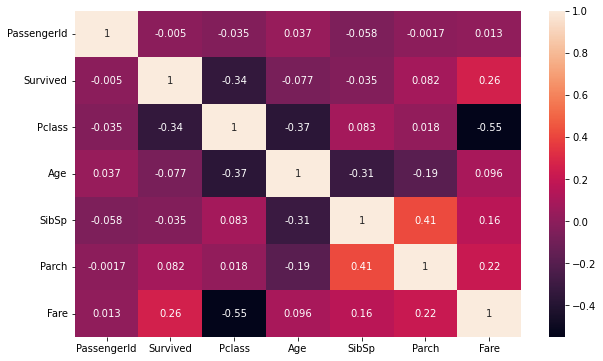

In [221]:
sns.heatmap(train.corr(), annot=True);
# Burada age ile pclass arasında yüksek korelasyon görüyoruz.fill value'ları pclass'a göre doldurabiliriz.

In [222]:
# Train Data
train.groupby("Pclass")["Age"].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [223]:
for class_ in train["Pclass"].unique():
    cond = train["Pclass"] == class_
    mean = train[cond]["Age"].mean()
    train.loc[cond, "Age"] = train.loc[cond, "Age"].fillna(mean)

In [224]:
train["Age"].isnull().sum()

0

In [225]:
# Test Data
for class_ in test["Pclass"].unique():
    cond = test["Pclass"] == class_
    mean = test[cond]["Age"].mean()
    test.loc[cond, "Age"] = test.loc[cond, "Age"].fillna(mean)

In [226]:
test["Age"].isnull().sum()

0

#### 2. Missing values in Cabin 

Since we have lots of null values for Cabin column, so it is better to remove it.

In [227]:
# Train DAta
train["Cabin"].isnull().value_counts(normalize=True)

True     0.771044
False    0.228956
Name: Cabin, dtype: float64

In [228]:
# Test Data
test["Cabin"].isnull().value_counts(normalize=True)

True     0.782297
False    0.217703
Name: Cabin, dtype: float64

In [229]:
# Evet gerçekten Cabin sütununda hem train hem de test kısmında %80' e yakın mising value var.

In [230]:
train.drop(columns="Cabin", inplace=True)
test.drop(columns="Cabin", inplace=True)

#### 3. Missing values in Embarked column

Since there are just two missing values, we shall impute them with the mode of the Embarked column.

In [231]:
# embarked	Port of Embarkation
# C = Cherbourg
# Q = Queenstown
# S = Southampton

In [232]:
# Train Data
train["Embarked"].value_counts(dropna=False)
# Bu bir categorik sütun olduğu için mode ile doldurabiliriz.

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [233]:
train["Embarked"].mode()[0]

'S'

In [234]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

In [235]:
train["Embarked"].isnull().sum()

0

In [236]:
# Test Data
test["Embarked"].value_counts(dropna=False)
# There is no null value.

S    270
C    102
Q     46
Name: Embarked, dtype: int64

#### 3. Missing values in Fare column in Test Dataset

Since there is one missing value, we shall impute them with the mean of the Fare column.

In [237]:
# Train Data
train["Fare"].isnull().sum()

0

In [238]:
# Test Data
test["Fare"].isnull().sum()

1

In [239]:
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

In [240]:
test["Fare"].isnull().sum()

0

## Creating new Features

* WE shall create a new column called **Family** by combining Parch and SibSp columns
 - sibsp : # of siblings / spouses aboard the Titanic
 - parch : # of parents / children aboard the Titanic


In [241]:
# Burada titanikteki eş ve çocuk sayılarını toplayarak FAmily isimli yeni bir sütun oluşturulacak.
train["Family"] = train["SibSp"] + train["Parch"]
train.drop(columns=["SibSp", "Parch"], inplace=True)

test["Family"] = test["SibSp"] + test["Parch"]
test.drop(columns=["SibSp", "Parch"], inplace=True)

In [242]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0


In [243]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family
0,892,3,"Kelly, Mr. James",male,34.5,330911,7.8292,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,363272,7.0000,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,240276,9.6875,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,315154,8.6625,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,3101298,12.2875,S,2


Let’s take a look at the Age column

In [244]:
train["Age"].describe()

count    891.000000
mean      29.292875
std       13.210527
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [245]:
train["Age"].isnull().sum()

0

the Age column needs to be treated slightly differently, as this is a continuous numerical column.we can separate this continuous feature into a categorical feature by dividing it into ranges.

In [246]:
# Burada yaş aralıklarına göre kategorilere ayırma yoluna gideceğiz.

cut_points = [0, 5, 12, 18, 35, 60, 100]
label_names = ["Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]

train["Age_categories"] = pd.cut(train["Age"], bins = cut_points, labels = label_names)
test["Age_categories"] = pd.cut(test["Age"], bins = cut_points, labels = label_names)

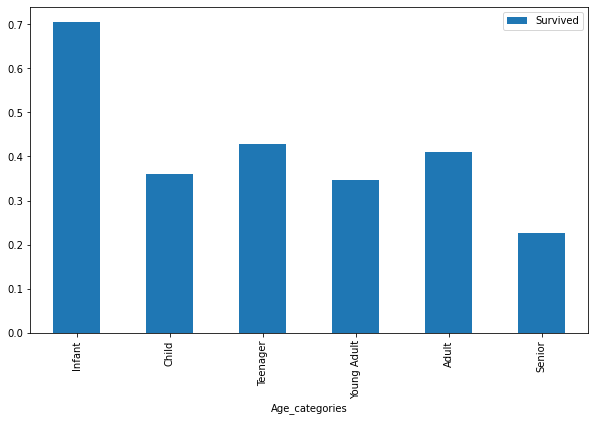

In [247]:
pivot = train.pivot_table(index = "Age_categories", values = "Survived")
pivot.plot(kind = "bar");

## Encoding Categorical Variables

We can use the pandas.get_dummies() function Now, we shall have to encode Sex, Embarked, Pclass and Age_categories. Name and Ticket columns have a lot of categories, hence we shall delete them.

In [248]:
train.head(3)
# Burada Pclass, Sex, Embarked, Age_categories column'ları kategorik olduğu için onlara get_dummies uygulayacağız.

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Family,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0,Young Adult


In [249]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass", "Sex", "Embarked", "Age_categories"]:
    train = create_dummies(train, column)
    test = create_dummies(test, column)

## Dropping Unnecessary columns

In [250]:
# dummy sonrası, eski sütunları siliyoruz.
train.drop(columns = ['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True)
test.drop(columns = ['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True)

In [251]:
train.head()

,PassengerId,Survived,Age,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,22.0,7.2500,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0
1,2,1,38.0,71.2833,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0
2,3,1,26.0,7.9250,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0
3,4,1,35.0,53.1000,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0
4,5,0,35.0,8.0500,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0


In [252]:
test.head()

,PassengerId,Age,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,892,34.5,7.8292,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0
1,893,47.0,7.0000,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0
2,894,62.0,9.6875,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
3,895,27.0,8.6625,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
4,896,22.0,12.2875,2,0,0,1,1,0,0,0,1,0,0,0,1,0,0


## Logistic Regression Implementation

We will use Logistic Regressionfrom [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model. The only change we will make from the default model settings is to lower the [regularization parameter](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default Logistic Regression.

The .fit() method accepts two arguments: X and y. X must be a two dimensional array (like a dataframe) of the features that we wish to train our model on, and y must be a one-dimensional array (like a series) of our target, or the column we wish to predict.

In [254]:
logistic_model = LogisticRegression()

In [207]:
X_train = train.drop(columns="Survived")
y_train = train["Survived"]

In [208]:
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
X_train = train.drop(columns="Survived")
y_train = train["Survived"]

### Evaluating Accuracy of our model

The evaluation criteria given on the Titanic Data page is accuracy, i.e how many correct predictions we have made out of the total predictions. We have created our model but how will we know how accurate it is? We do have a Test dataset but since it doesn't have the Target column, everytime we optimize our model, we will have to submit our predictions to public Leaderboard to assess it accuracy. 

#### Creating a Validation set

Another option would be to create a validation set from the training set. We will hold out a part of the training set during the start of the experiment and use it for evaluating our predictions. We shall use the scikit-learn library's `model_selection.train_test_split()` function that we can use to split our data

#### Making predictions and measuring accuracy

#### Using cross validation for more robust error measurement

#### Making Predictions on Test data

## Submission 

We can still can improve our model,however this notebook is intended to show how we can do some exploratory analysis, clean up data, perform predictions using Logistic regression Algorithm. In the Next notebook, I shall go in detail about Decision Trees and Random Forests.